# Assignment 3: Clustering California Housing with K-means

### CS 6316 Machine Learning - Department of Computer Science - University of Virginia
"Tonight, more than 130,000 Californians will go to sleep homeless. That’s enough to fill Dodger Stadium, AT&T Park and Petco Park. The biggest culprit is rising housing costs. From 2000 to 2014, median rent in California increased by more than one-third, while real incomes for renters fell by 7 percent. Today, 1.5 million Californians spend more than half their income on housing. This crisis threatens not just low-income families but our entire economy, driving businesses to relocate to states in which their employees can afford to live. - **Business Insider, Sep 2018.**"

![Half of the homes in San Franciso is now one million or above](https://amp.businessinsider.com/images/573de0b88d3eaea27198a55d-960-480.jpg)

In this assignment, you will attempt to cluster the California Housing by implementing and analyzing the k-means algorithm to the data. K-Means is one of the most popular clustering algorithms. K-means stores k-centroids that it uses to define clusters. A point is considered to be in a particular cluster if it is closer to that cluster's centroid than any other centroid. For references, you may refer to my lecture 9 or Chapter 2 of the textbook if you need additional sample codes to help with your assignment. For deliverables, you must write code in Python and submit this Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.


---
## 1. PRE-PROCESSING THE DATA (10 pts)

Download the California Housing dataset from the below link. This dataset includes statistics about the median income, median age, average number of rooms per person, average number of persons in a household etc. The statistics were gathered per geographical block.

**Data Acquiring:** Download the dataset from https://www.kaggle.com/camnugent/california-housing-prices

**Data Discovery, Visualization, and Cleaning:** Fortunately, this step have been given to you (for free) from chapter 2. However, you should review them and write the code necessary for the purposes of this assignment. 

### Data Acquisition

In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer, StandardScaler
from future_encoders import ColumnTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline

def load_data(dir_path, filename):
    csv_path = os.path.join(dir_path, filename)
    return pd.read_csv(csv_path)

data=load_data("", "housing.csv")

### Data Discovery and Visualization

There are 10 features including one categorical feature (ocean_proximity) in the dataset.

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Looking at correlations might not make much sense because the goal is to cluster based on all features, and not to compare features to a target label. However, it would make sense to see where the houses are situated based on their prices and population.

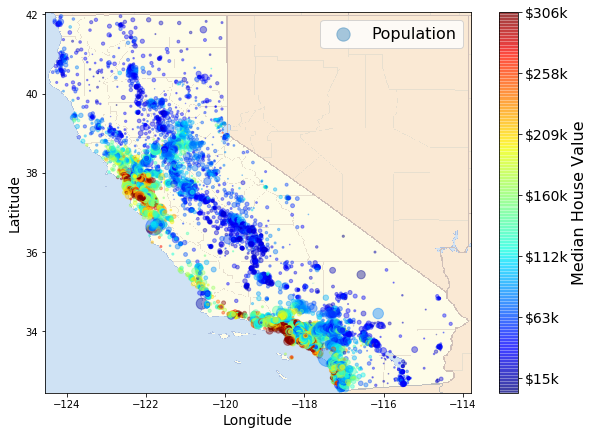

In [3]:
import matplotlib.image as mpimg
california_img=mpimg.imread('california.png')
ax = data.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=data['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = data["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

### Data Cleaning

In [67]:
fields=data.columns.values.tolist()
cat_attribs=["ocean_proximity"]
#scale everything excluding latitude and longitude.
num_attribs=list(set(fields)-set(cat_attribs) - set(["longitude","latitude"]))

num_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

data_prepared = full_pipeline.fit_transform(data)

#data_prepared does not contain longitude and latitude values for clustering as this skew the data
longitudes = np.array(data["longitude"])
latitudes = np.array(data["latitude"])

print(data.shape)
print(data_prepared.shape)

(20640, 10)
(20640, 12)


- - -
## 2. IMPLEMENTING K-MEANS (40 pts)

You must implement your own version of K-Means Algorithm. Input a cluster count K and M data points each with its own vector of N features, along with the choice of a distance measure; then:

1. Initialize K centroids. In our case, a centroid is just the average of all data in a cluster, and it can be represented just like a normal cluster.
2. Assign each data point to the cluster that has the closest centroid base on a **distance measure**.
3. After all data points have been assigned to clusters, recalculate the centroids for each cluster (as averages of all points in the cluster).
4. Repeat the data assignments and centroid calculations until no change in gene assignment occurs between iterations.

**Distance Measures:** Your implementation must have an option of using two distance measures for clustering: 
- Euclidean distance: Euclidean distance measures differences in the absolute levels of instances.
$d(\mathbf{x},\mathbf{y}) = \sqrt[\leftroot{2}\uproot{2}2]{\sum\limits_{i=1}^n|x_i - y_i|^2}$
- Spearson rank correlation: Spearson rank correlation uses ranks in place of absolute values, which makes it less sensitive to outliers (extremely high or low values) in the data.
$d(\mathbf{x},\mathbf{y}) = \frac{\sum_i (x^{(i)} - \bar{x})(y^{(i)} - \bar{y})}{\sqrt{\sum_i (x^{(i)} - \bar{x})^2 \sum_i (y^{(i)} - \bar{y})^2}}$

**Implementation Notes:** Note that these functions should return distance measures; that is, the returned value should be high if the two vectors are dissimilar, low if they are similar, and zero if they are completely identical. This requirement is already met for Euclidean distance, but Spearson rank correlation varies between -1 and 1, and high values indicate similarity. Therefore, you must transform the Spearson rank correlation so that the returned value is always greater than or equal to zero, with high values indicating dissimilarity.

In [60]:
from math import sqrt
from copy import deepcopy

def sum_squares(a, axis=0):
    return np.sum(a*a, axis)

def ec_dist(pointA, pointB):
    return np.sqrt(sum_squares(pointA - pointB))

def spearman_corr_dist(pointA, pointB):
    mean_A = pointA.mean()
    mean_B = pointB.mean()

    mean_diff_A = pointA - mean_A
    mean_diff_B = pointB - mean_B
    
    numerator = np.add.reduce(mean_diff_A * mean_diff_B)
    denom = np.sqrt(sum_squares(mean_diff_A) * sum_squares(mean_diff_B))
    r = numerator / denom
    return 1 - r

In [66]:
def get_random_centroids(array, clusters):
    r = np.random.RandomState(42)
    idx = r.randint(array.shape[0], size=clusters)
    return array[idx,:]

# Function: K Means
# -------------
# K-Means is an algorithm that takes in a dataset and a constant
# k and returns k centroids (which define clusters of data in the
# dataset which are similar to one another).

class KMeansClustering:
    """
    The class takes two parameters:
        clusters takes the value of K i.e. number of clusters
        distance_measure takes either euclidean or spearman_rank and defaults to euclidean
    """
    def __init__ (self, clusters, distance_measure = "euclidean"):
        self.clusters = clusters
        if(not distance_measure in ["euclidean", "spearman_rank"]):
            distance_measure = "euclidean"
        self.distance_measure = distance_measure
        self.labels_ = []
        self.centroids_ = []
        self.SSE_ = 0
        self.cluster_std_ = []
        
    #expects a numpy array as input X
    def fit(self, X):
        number_of_instances = X.shape[0]
        number_of_features = X.shape[1]
        
        distance_function = ec_dist if self.distance_measure == "euclidean" else spearman_corr_dist
        
        #randomly initialize K centroids
        #each centroid would be a list of n features
        #For each instance in X, 
            #find the distance to each of the K centroids
            #tag the instance with the cluster_id of the one it is closest to
        centroids = get_random_centroids(X, self.clusters)
        
        centroidNeedsUpdate = True
        #Update conditions
        while centroidNeedsUpdate:            
            cluster_instance_map = {}
            for cluster_id in range(self.clusters):
                cluster_instance_map[cluster_id] = []
            
            i=0
            while(i < number_of_instances):
                current_instance = X[i]
                #initialize min to the first distance and then iterate from 1 to K-1
                min_dist = distance_function(current_instance, centroids[0])
                closest_centroid = 0

                j=1
                while(j < self.clusters):
                    current_centroid = centroids[j]
                    dist_to_current_centroid = distance_function(current_instance, current_centroid)
                    if(dist_to_current_centroid < min_dist):
                        closest_centroid = j
                        min_dist = dist_to_current_centroid
                    j+=1

                cluster_instance_map[closest_centroid].append(i)
                i+=1

            #check if you need to update centroid
            update = False
            for centroid_id in range(self.clusters):
                current_centroid = centroids[centroid_id]
                
                points_for_current_centroid = np.take(X, cluster_instance_map[centroid_id], axis=0)
                
                recomputed_centroid = np.mean(points_for_current_centroid, axis = 0)
                
                if(not np.array_equal(current_centroid, recomputed_centroid)):
                    centroids[centroid_id] = deepcopy(recomputed_centroid)
                    update = True
            
            centroidNeedsUpdate = update
        labels = [0] * number_of_instances
        sse = 0
        cluster_std_dev = [0] * self.clusters
        for cluster_id, indices in cluster_instance_map.items():
            for index in indices:
                labels[index] = cluster_id

            #calculating sse
            current_centroid = centroids[cluster_id]
            points_for_current_centroid = np.take(X, cluster_instance_map[cluster_id], axis=0)
            sse += sum(map((lambda x: sum_squares(x, axis=0)), points_for_current_centroid - current_centroid))
            #calculating std for each attirbute within cluster
            cluster_std_dev[cluster_id] = np.std(points_for_current_centroid, axis=0)
            
        self.labels_ = deepcopy(labels)
        self.centroids_ = deepcopy(centroids)
        self.SSE_ = sse
        self.cluster_std_ = cluster_std_dev

## 3. CLUSTERING HOUSING INTO REGIONS (30 pts)

Now that you have implemented the K-Means as the clustering algorithm. Applying the algorithm for 2 clusters to see if you can split California into a Northern and Southern regions.

**Cluster the data:** Write down the SSE (sum squared error), cluster means, within cluster standard deviations for each attribute, etc. Visualize the clustering by plot the latitude along the X axis and longitude along the Y axis. You should get a plot that looks roughly in the shape of California (see Chapter 2 for more details). Using the cluster means and std. deviations as representative values in the cluster, what can you say about the clusters that were found? How do they compare with what you know about cities and areas in California? What can you attribute the gaps to? It will definitely be helpful to have a map of California handy.

**Change the number of clusters:** Change K from 2 to 10 and repeat the clustering process above. Record cluster means and standard deviations. When you change K, do any additional patterns emerge? If so, what are they?
Applying the algorithm for 10 clusters to see if it clearly identified the silicon valley area as one cluster (where houses are relatively new and expensive, median income is high), the area of San Francisco as another etc. While SF and Silicon Valley may have a somewhat similar profile (at least, compared with mid CA), they were separated mainly due to the latitude/longtitue properties, that involve a dimension of geographical cohesiveness.

**Implementation Notes:** For each k, report the training and validation accuracy for EACH similarity measure. Identify the k with the highest validation accuracy, and report the test accuracy with this choice of k. Note: if multiple values of k result in the highest validation accuracy, then report test accuracies for all such values of k. Then, plot the data points with different markers corresponding to different classes. Repeat this process for all k and discuss the smoothness of the decision boundaries as k increases.


## Cluster the data

### Run \#1: K=2, Euclidean Distance Measure

In [50]:
k_means = KMeansClustering(2)
k_means.fit(data_prepared)
print(f"Sum Squared Error = {k_means.SSE_}")
for k in range(k_means.clusters):
    print(f"Cluster {k}\n--")
    print(f"Cluster Means: \n{k_means.centroids_[k]}")
    print(f"Std Deviation for each attribute: \n{k_means.cluster_std_[k]}\n")

Sum Squared Error = 114769.13576141479
Cluster 0
--
Cluster Means: 
[ 1.88185658  0.1449556   2.03719317 -0.87856859  0.1655712   2.03897953
  1.96491485  0.47008547  0.33076923  0.          0.08803419  0.11111111]
Std Deviation for each attribute: 
[1.65497137 0.93792278 1.51880226 0.74037633 0.94116245 1.49387631
 1.66582088 0.49910432 0.47049011 0.         0.28334461 0.31426968]

Cluster 1
--
Cluster Means: 
[-2.40630841e-01 -1.85353059e-02 -2.60493553e-01  1.12341558e-01
 -2.11713994e-02 -2.60721972e-01 -2.51251407e-01  4.39125683e-01
  3.15683060e-01  2.73224044e-04  1.13879781e-01  1.31038251e-01]
Std Deviation for each attribute: 
[0.51663241 1.00615723 0.48412135 0.97285983 1.00531125 0.49287475
 0.46499797 0.49628048 0.46478733 0.01652723 0.3176652  0.33744218]



### Visualization

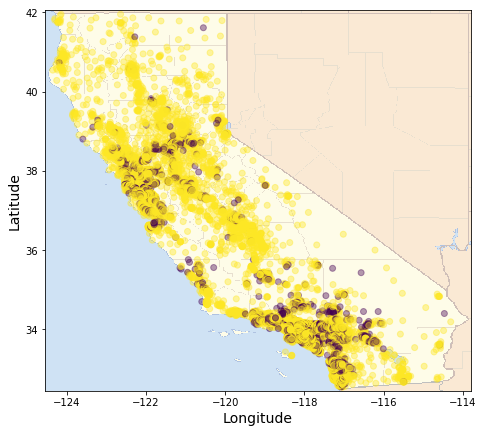

In [51]:
plt.figure(figsize=(10,7))
plt.scatter(longitudes, latitudes, c=k_means.labels_, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.show()

From the visualization, the first clustering for K=2 primarily shows the mostly populated and highly priced cities. The yellow cluster shows the lower prices places in California, whereas the ones in purple can be called as the more expensive places (the clustering is not totally based on the price, but it gives a first level indication).

The purple cluster includes places like San Francisco, San Jose, and Sacramento in the northern side. It also includes Los Angeles, Pasadena, and San Diego in the south. These places are generally known for higher median housing prices. This can be seen in the first map visualization in the notebook.

### Run \#2: K=2, Spearman Correlation Distance

In [61]:
k_means = KMeansClustering(2, distance_measure="spearman_rank")
k_means.fit(data_prepared)
print(f"Sum Squared Error = {k_means.SSE_}")
for k in range(k_means.clusters):
    print(f"Cluster {k}\n--")
    print(f"Cluster Means: \n{k_means.centroids_[k]}")
    print(f"Std Deviation for each attribute: \n{k_means.cluster_std_[k]}\n")

Sum Squared Error = 124195.93316616205
Cluster 0
--
Cluster Means: 
[ 0.73178213 -0.21085168  0.77186403 -0.70967946 -0.12379634  0.76890518
  0.70788842  0.39434233  0.41793769  0.          0.06348586  0.12423413]
Std Deviation for each attribute: 
[1.25838047 0.82637827 1.23137338 0.73457164 0.82386461 1.22589364
 1.28537351 0.48870897 0.49321981 0.         0.24383478 0.32984846]

Cluster 1
--
Cluster Means: 
[-4.32839902e-01  1.24716113e-01 -4.56547841e-01  4.19766451e-01
  7.32239743e-02 -4.54797722e-01 -4.18707073e-01  4.71200555e-01
  2.57922739e-01  3.85534737e-04  1.39023826e-01  1.31467345e-01]
Std Deviation for each attribute: 
[0.38827768 1.07037812 0.3657839  0.89343157 1.0842449  0.38216993
 0.37752783 0.4991699  0.43749126 0.01963125 0.34597139 0.33791076]



### Visualization

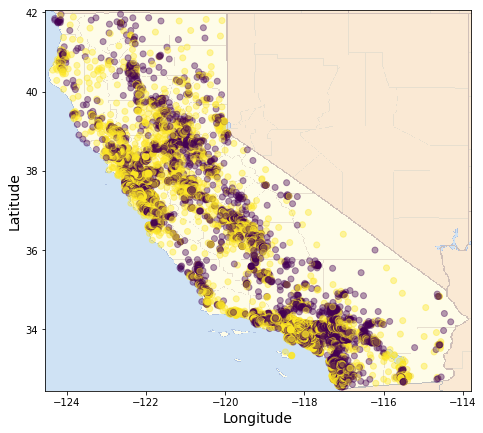

In [63]:
plt.figure(figsize=(10,7))
plt.scatter(longitudes, latitudes, c=k_means.labels_, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.show()

## Changing the number of clusters

Let's see if the clustering can bring out more patterns for K=10.

### Run \#3: K=10, Euclidean Distance

In [54]:
k_means = KMeansClustering(10)
k_means.fit(data_prepared)
print(f"Sum Squared Error = {k_means.SSE_}")
for k in range(k_means.clusters):
    print(f"Cluster {k}\n--")
    print(f"Cluster Means: \n{k_means.centroids_[k]}")
    print(f"Std Deviation for each attribute: \n{k_means.cluster_std_[k]}\n")

Sum Squared Error = 51014.12388624045
Cluster 0
--
Cluster Means: 
[ 0.63387328  1.16350191  0.77462678 -0.56997473  0.93357012  0.81825776
  1.01401767  0.66295979  0.05303678  0.          0.11206159  0.17194183]
Std Deviation for each attribute: 
[0.48931001 0.73370325 0.53143361 0.71951193 0.81017815 0.512302
 0.57591023 0.47269875 0.22410686 0.         0.31544221 0.37732988]

Cluster 1
--
Cluster Means: 
[-0.36563305  0.35972687 -0.4096724  -0.58118485  0.66563016 -0.39407003
 -0.26101626  0.68034188  0.13435897  0.          0.0642735   0.12102564]
Std Deviation for each attribute: 
[0.34431977 0.55800321 0.32329464 0.66634709 0.59526383 0.33169877
 0.36745008 0.46634409 0.34103759 0.         0.24523952 0.32615707]

Cluster 2
--
Cluster Means: 
[ 0.26356777 -0.28527564  0.12932353  0.38740613 -0.47903993  0.15734047
 -0.05676906  0.62810195  0.13044936  0.          0.08484239  0.1566063 ]
Std Deviation for each attribute: 
[0.45546338 0.48738831 0.33004443 0.59695316 0.46938706 0.3

### Visualization

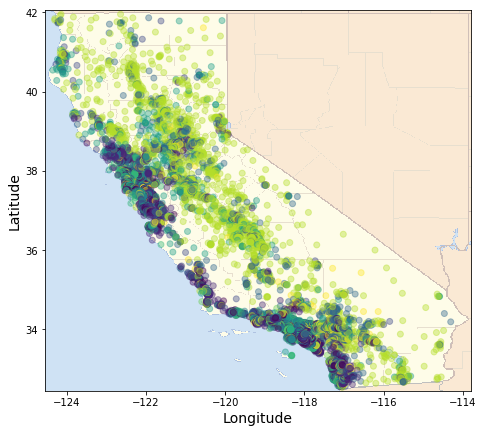

In [55]:
plt.figure(figsize=(10,7))
plt.scatter(longitudes, latitudes, c=k_means.labels_, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.show()

For K=10, this clearly shows the "hot" real estate places. If you observe closely, the ones that are marked yellow are San Francisco, San Jose, Los Angeles, and San Diego. The ones marked purple are the next higher priced ones. The green points represent the lower priced areas. This is a much better clustering and is more accurate in terms of the known housing prices about these places. It also picks up ocean proximity areas as part of yellow, teal, and purple clusters. 

Moreover, Silicon Valley with coordinates (37, -122) is clearly demarcated in the yellow and dense purple cluster. This shows that the yellow cluster represents higher median housing prices as well as income.

### Run \#4: K=10, Spearman Correlation Distance (takes approx. 12mins to converge without any tolerances set)

In [64]:
k_means = KMeansClustering(10, distance_measure="spearman_rank")
k_means.fit(data_prepared)
print(f"Sum Squared Error = {k_means.SSE_}")
for k in range(k_means.clusters):
    print(f"Cluster {k}\n--")
    print(f"Cluster Means: \n{k_means.centroids_[k]}")
    print(f"Std Deviation for each attribute: \n{k_means.cluster_std_[k]}\n")

Sum Squared Error = 67836.91044750523
Cluster 0
--
Cluster Means: 
[-0.46303045  1.55466679 -0.28626894  0.95983864  0.35370969 -0.28002819
 -0.27685847  0.41995614  0.05208333  0.00219298  0.25657895  0.2691886 ]
Std Deviation for each attribute: 
[0.3735773  0.67851768 0.48104119 0.71174658 0.68736782 0.49180813
 0.40380598 0.4935514  0.22219509 0.04677791 0.436745   0.44353816]

Cluster 1
--
Cluster Means: 
[ 0.23957675  0.63618688  0.23353819 -0.99186587  0.85895129  0.26615509
  0.49168895  0.77735849  0.06855346  0.          0.05974843  0.09433962]
Std Deviation for each attribute: 
[0.48911331 0.74305223 0.47964992 0.55655628 0.77260275 0.4765615
 0.66522835 0.41601955 0.25269326 0.         0.23702015 0.29230063]

Cluster 2
--
Cluster Means: 
[ 0.54553169 -0.29011383  0.2943394  -0.04600622 -0.63066191  0.3263062
 -0.04134966  0.96318212  0.          0.          0.00723208  0.0295858 ]
Std Deviation for each attribute: 
[0.62750394 0.45742912 0.42015295 0.66684643 0.41958108 0.4

### Visualization

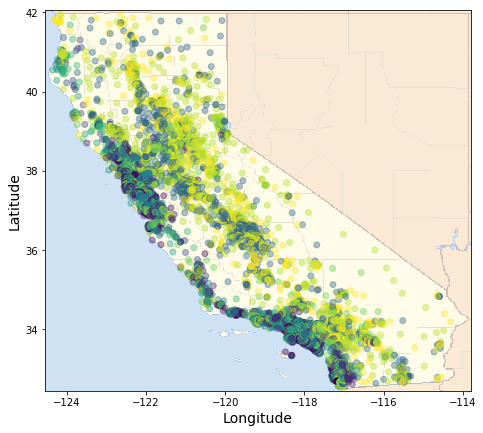

In [65]:
plt.figure(figsize=(10,7))
plt.scatter(longitudes, latitudes, c=k_means.labels_, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.show()

- - -
## 4. WRITE ON THE INTUITION FOR THE CALIFORNIA HOUSING CRISIS (20 pts)

This question is a qualitative one, and is intended to let you experiment with a real world clustering task. Hopefully it gives you some intuition as for how the preset number of clusters affects the clustering results. Too few clusters may not reveal the information that is in the data. Too many clusters may hurt data analysis as well, as it may not generalize (and in this sense, it is equivalent to over fitting). Additionally, did you have any insight on which similarity measure (either Eucledean or Spearson Correlation) work better in this dataset.

Write at least one paragraph to demonstrate your intuition on the California Housing Crisis. You might also want to mention some possible solutions to solve it. You will receive credits based upon your insights and intuitions on this challenge. 



### Intuition and possible solution

The SSE values are better for euclidean distance in comparison to spearman correlation distance. Also, it takes faster time to converge. If you compare the visaulizations for the clusterings for K=2, even in this case the superior clustering is done by the euclidean distance measure. Hence, euclidean distance is a better metric for this dataset. 

The major intuition that I can surmise is that the role of median income is massive. Especially, for places like Silicon Valley where the best paid software engineers live, the housing prices are highly correlated. Each year, a major chunk of people relocate to these places in search of the best jobs. It is a fact that the jobs offered here are indeed lucrative. But when looking at the bigger picture, this means increase in population and also scarcity for housing resources. The real estate agencies make a huge profit out these since, they know that housing is such a scarce resource and the income of the people looking for these are also high that they can keep increasing housing prices every year. This creates a major issue for the middle and lower class of the society and a lot of people find it hard to afford their rents.

I think to make a positive change, the government could take drastic measures in controlling inward flow of people into these already dense places. Maybe the software companies could establish offices in neighboring states and accommodate their newly employed people there. This would turn out better due to lesser expenditure for the employees and also less infrastructure cost for the companies. But this has to be enforced by the government.


- - - 
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my lectures and/or the textbook
 * Talk to the TA, they are available and there to help you during [office hour](https://docs.google.com/document/d/15qB84xjaS-uRJmfKmmQuCz38bLMFaoqdbuRLoZEdOYI/edit#heading=h.72k1pvft525n)
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS6316 Assignment 3:...".

Best of luck and have fun!